In [4]:
import re

import numpy as np
from tensorflow.python.keras.layers import Dropout, Dense, SimpleRNN, LSTM
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.python.keras.models import Sequential

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

NameError: name 'os' is not defined

In [31]:
def select():
    path = './models'
    a = os.listdir(path)
    c = []
    b = sorted(a)
    f = []
    for i, j in enumerate(b):
        c.append(float((re.findall(r"\d+\.?\d*", j[0:5]))[0]))
        f.append(j)
    # d = sorted(np.array(c), key=float)
    # e = argsort(d)
    # g = f[int(e[0])]
    # print(g)
    d = c.index(min(c))
    d = f[d]
    print(d)
    return d

In [51]:
pre_time = 10
mem_his_days = 5
unit = 20
dense_layers = 'lstm+cnn'
lstm_layers = 3
epochs = 100
test_size=0.2

In [52]:
data = pd.read_csv('./data2/handle_Turbine_Data .csv')
df = pd.DataFrame(data)
df.dropna(inplace=True)

df.sort_index(inplace=True)
# print(df.head())
df['label'] = df['ActivePower'].shift(-pre_time)
# # print(df['label'])
# # print(df.iloc[:,:-1])
scaler = StandardScaler()
sca_X = scaler.fit_transform(df.iloc[:,:-1])

In [53]:
from collections import deque
deq = deque(maxlen=mem_his_days)
X = []
for i in sca_X:
    deq.append(list(i))
    if len(deq) == mem_his_days:
        X.append(list(deq))
X_lately = X[-pre_time:]
X = X[:-pre_time]
# print(len(X))
# print(len(X_lately))
y = df['label'].values[mem_his_days-1:-pre_time]


In [54]:
X = np.array(X)
y = np.array(y)
print(y)

[-4.7576295  -5.21963507 -6.63190271 ... 20.77778972 62.09103858
 68.66442478]


In [112]:
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.metrics import MeanSquaredLogarithmicError
filepath = './models/{val_mean_squared_logarithmic_error:.4f}_{epoch:02d}_'+f'men_{mem_his_days}_lstm_{lstm_layers}_dense_{dense_layers}_unit_{unit}_test_size_{test_size}'
checkpoint = ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_mean_squared_logarithmic_error',
    mode='min',
    save_best_only=True
                    )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,shuffle=False)


In [ ]:
model = Sequential()
model.add(LSTM(unit, input_shape=X.shape[1:],activation='relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(unit,activation='relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(SimpleRNN(unit,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(unit, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer='Adam',loss='mae',metrics=[MeanSquaredLogarithmicError()])
history = model.fit(X_train, y_train, batch_size=64,epochs=epochs,validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/100
404/404 [==============================] - 15s 32ms/step - loss: 305.1411 - mean_squared_logarithmic_error: 5.3404 - val_loss: 269.2645 - val_mean_squared_logarithmic_error: 4.2974
INFO:tensorflow:Assets written to: ./models\4.2974_01_men_5_lstm_3_dense_lstm+rnn_unit_100_test_size_0.2\assets
Epoch 2/100
404/404 [==============================] - 14s 35ms/step - loss: 250.6224 - mean_squared_logarithmic_error: 3.9045 - val_loss: 249.3138 - val_mean_squared_logarithmic_error: 3.9105
INFO:tensorflow:Assets written to: ./models\3.9105_02_men_5_lstm_3_dense_lstm+rnn_unit_100_test_size_0.2\assets
Epoch 3/100
404/404 [==============================] - 16s 40ms/step - loss: 243.7148 - mean_squared_logarithmic_error: 3.7196 - val_loss: 247.1477 - val_mean_squared_logarithmic_error: 3.9878
Epoch 4/100
404/404 [==============================] - 16s 41ms/step - loss: 239.8922 - mean_squared_logarithmic_error: 3.6306 - val_loss: 238.8621 - val_mean_squared_logarithmic_error: 3.6108
INFO

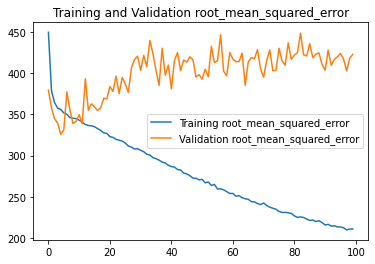

In [95]:
loss = history.history['root_mean_squared_error']
val_loss = history.history['val_root_mean_squared_error']

plt.plot(loss, label='Training root_mean_squared_error')
plt.plot(val_loss, label='Validation root_mean_squared_error')
plt.title('Training and Validation root_mean_squared_error')
plt.legend()
plt.show()


3.6078_07_men_5_lstm_3_dense_lstm+rnn_unit_100_test_size_0.2


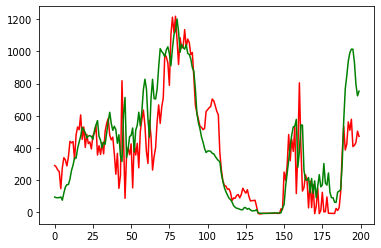

In [106]:
from tensorflow.python.keras.models import load_model

best_model = load_model('./models/'+ str(select()))

pre = best_model.predict(X_test)
import matplotlib.pyplot as plt
# df_time = df['date'][-len(y_test):].values
# print(df_time)
# pre = pre.reshape(724,)
# print(pre)
# print(y_test)

plt.plot(y_test[200:400],color='red',label='price')
plt.plot(pre[209:409],color='green',label='predict')
plt.savefig('./save.png',)
plt.show()